In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn import metrics
%matplotlib inline




# Statistique descriptive

#### Sans commencer la partie modélisation, quels sont les facteurs qui semblent influencer lademande en vélos ? Justifiez vos choix. Présentez quelques graphiques pertinents pour illustrer votre réponse et interprétez-les.

In [2]:
df=pd.read_csv("data.csv") #données sont télécharger dans une table pandas
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
df.shape


(10886, 12)

In [4]:
df.dtypes


datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [5]:
df['datetime']=pd.to_datetime(df['datetime']) 
# on transforme les données temporelles
df['Day'],df['hour']=zip(*[(d.date(),d.time().hour) for d in df.datetime]) # crée deux nouvelle colonne avec la date et l'heure 
df_datetime=df['datetime']#on garde les dates à part au cas où nous en aurions besoin 
del df['datetime']

In [6]:
df.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
Day            object
hour            int64
dtype: object

### Variation du nombre de vélos loués par heure.

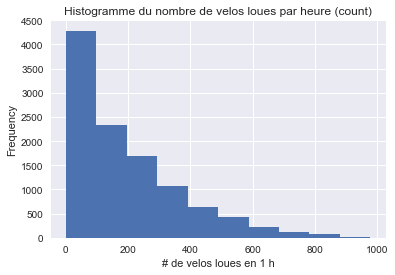

In [7]:
histo_cnt_hour=df['count'].plot.hist()
histo_cnt_hour.set_xlabel('# de velos loues en 1 h')
histo_cnt_hour.set_title('Histogramme du nombre de velos loues par heure (count)')


Ici nous voyons la variation  du nombre de velos loué par heure. Il y a beaucoup d'heures ou très peu de vélos seront loués. Une hypothèse simple est que beaucoup moins de vélos seront loués la nuit que le jour. 

Il y a plusieurs facteurs que l'on peut penser avoir de l'influence sur la variable count. La saison, l'heure du jour, la température. 




In [8]:
df_count_day=df.groupby(df.Day)['count'].sum()
df_count_day.head()

Day
2011-01-01     985
2011-01-02     801
2011-01-03    1349
2011-01-04    1562
2011-01-05    1600
Name: count, dtype: int64

### Evolution temporelle du nombre de vélos loués

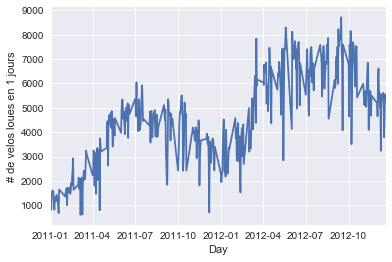

In [9]:
count_day_plot=df_count_day.plot()
count_day_plot.set_ylabel('# de velos loues en 1 jours')

Dans ce graphique, nous voyons la distribution du nombre de vélos loués à chaque jours. Ce que nous pouvons est que la série temporelle est pas du tout stationnaire de façon globale le nombre de vélos augmente dans le temps et qu'il y  a des variations saisonières: moins de vélos seront loués en hiver qu'en été, en fait ce que l'on voit c'est une diminution de l'augmentation.

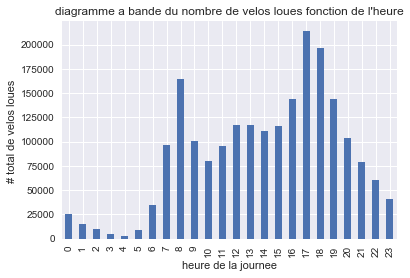

In [10]:
#histogram of the count per hour
bar_Time=df.groupby(df.hour)['count'].sum().plot.bar()
bar_Time.set_ylabel('# total de velos loues ')
bar_Time.set_xlabel('heure de la journee')
bar_Time.set_title('diagramme a bande du nombre de velos loues fonction de l\'heure')

La variation du nombre du nombre total de velos loues en fonction de l'heure du jour. Comme nous voyons ici, la difference entre le nombre de velos loues la nuit est tres different que dans la journée. Il y a plus de velos loues le matin qu'en fin d'apres midi. On voit donc que la serie temporelle n'est pas stationnaire : elle augmente dans le temps qu'il y a une différence marquée entre les saisons et que l'heure de la journée est un critere tres important.

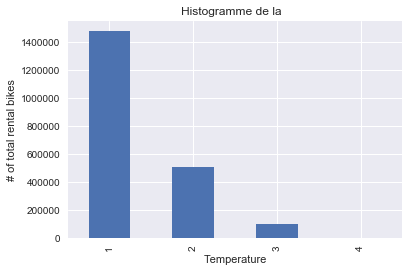

In [11]:
bar_weather=df.groupby(df.weather)['count'].sum().plot.bar()
bar_weather.set_ylabel('# of total rental bikes')
bar_weather.set_xlabel('Temperature')
bar_weather.set_title('Histogramme de la  ')

In [12]:
df.groupby(df.weather)['count'].sum()

weather
1    1476063
2     507160
3     102089
4        164
Name: count, dtype: int64

Alors, ce que l'on voit dans le graphique plus haut, et que confirme l'histogramme c'est l'influence de la température sur la location de vélo. 1=dégagé à nuageux, 2=Brouillard, 3= légère pluie ou neige et 4=Fortes averses ou neiges. Ce que l'on voit c'est un peu se douter il n'y a presque pas de location de vélo dans la catégorie 4. 

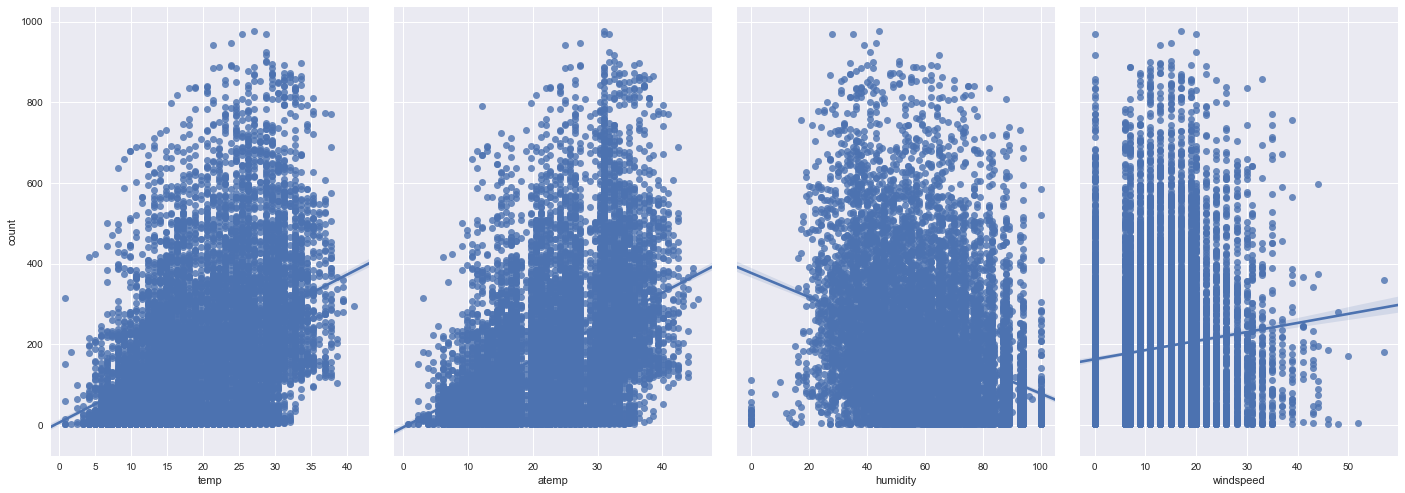

In [13]:
sns.pairplot(df,x_vars=['temp','atemp','humidity','windspeed'],y_vars='count',size=7,aspect=0.7,kind='reg')

Alors ici ce que l'on voit c'est la variable count fonction de la température de la température ressentie, de l'humidité et de la vitesse des vents.  Ce que l'on voit, c'est que les distribution son très large (ca ne semlbe pas être une régression linéaire). Aussi, comme le confirme plus bas le coefficient corrélation entre les deux variables la température ressentie est très reliée à la température. 

In [14]:
print df['temp'].corr(df['atemp'])

0.984948110482


Comme on pouvait l'imaginer de par leur definition (temperature reelle et sentie) et par le graphique de leur relation a la variable count, les variables temp et a temp sont tres similaire. On gardera donc que la variable 'atemp'.

In [15]:
del df['temp']


In [16]:
df.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
Day            object
hour            int64
dtype: object

Pour les variables discrete ou continue (holiday, workingday, atemp, humidity et windspeed) on peut mesurer la corrélation lineaire (pearson) avec la variable count. 

### Coefficent de corrélation Pearson

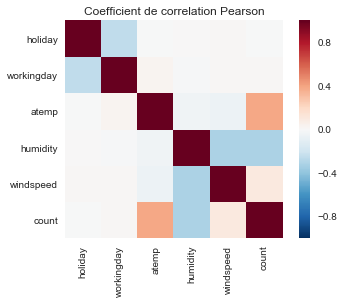

In [17]:
cm=df.loc[:,['holiday','workingday','atemp','humidity','windspeed','count']].corr()
sns.heatmap(cm,square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("Coefficient de correlation Pearson")

In [18]:
print cm['count']

holiday      -0.005393
workingday    0.011594
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
count         1.000000
Name: count, dtype: float64


Ce que l'on voit ici est le coefficient de corrélation linéaire entre les différentes varriables.La varriable holiday a un tres petit coefficient et ne semble pas avoir aucun impact sur count (puisque elle est binaire) nous pouvons donc s'en debarasser.

In [19]:
del df['holiday']

## 2. 
#### En supposant que vous ayez accès au sexe et à l’âge des utilisateurs abonnés, quelle procédure statistique vous permettrait de dire si les distributions en âge des deux populations (femme et homme) sont identiques ou non ? Décrivez les étapes de votre raisonnement.

Ici, nous ne pouvons pas faire l'hypothèse que la distribution de l'age pour la location de vélo est normale. On ne peut donc pas appliquer un t-test pour rejeter l'hypothèse nulle que la distribution de l'age pour les hommes et les femmes serait la même. Il existe un autre test le Mann-Whitney U test. Ici, on satisfait à toute les conditions:
1- Il n'y a pas d'individus qui sont dans les deux groupes (à la fois hommes et femmes).
2- La réponse (l'âge) est ordinal.
3-l'hypothèse (H0) nulle serait de dire que la distribution est la même pour les hommes et les femmes. 
4- Dans l'hypothèse contraire, les distributions ne sont pas égales.

Ce test est disponible dans scipy.stats sous-le nom mannwhitneyu(x,y).

# Machine learning

Pour le moment puisque count est la somme de casual + registred on enleve c'est deux variables il pourrait interessant de voir si batir deux modeles distinct pourrait ameliorer les resultats dans un temps ulterieur. 

In [20]:
del df['casual']
del df['registered']

On doit maintenant diviser la date en annee, mois et jours.

In [21]:
df['year'],df['month'],df['day']=zip(*[(d.year,d.month,d.day) for d in df.Day])
del df['Day']

In [22]:
df.dtypes

season          int64
workingday      int64
weather         int64
atemp         float64
humidity        int64
windspeed     float64
count           int64
hour            int64
year            int64
month           int64
day             int64
dtype: object

La variable count est la variable que l'on doit prévoir. Nous pouvons donc la separer du reste dans une variable Y.

In [23]:
Y=df['count']
del df['count']

La table df contient trois types de variables. Une variable binaire workingday, des variables de categories (season, weather, hour,month, year) et des variables continues (atemp,humidity,windspead). Les variables de categories doivent etre binarisés en créant des variables vides avec valeur 1 ou 0.

In [24]:
df=pd.get_dummies(df,columns=['season','weather','hour','month','year'])


Comme c'est de la prediction temporelle (forecasting) je garde les deux derniers mois pour tester le modele, puisque toute les données ne sont pas égale dans le temps.

In [25]:
X_train=df[:-24*61]
X_test=df[-24*61:]
Y_train=Y[:-24*61]
Y_test=Y[-24*61:]
print X_train.shape
print X_test.shape


(9422, 51)
(1464, 51)


## Random Forest

#### Concevez un modèle permettant de prédire la variable count et expliquez votre choixd’algorithme. Si votre modèle comporte des spécificités de paramétrage, justifiez également vos choix de paramètres.

Ce genre de problème Bike sharing data set est bien connu, il y a plusieurs exemples sur le web. et il semblerait que le type de modèle qui fonctionne le mieux est le random forrest.


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
rf=RandomForestRegressor()


In [27]:
def rmsle(predicted, actual):
    assert(len(predicted) == len(actual))
    p = np.log(np.array(predicted) + 1)
    a = np.log(np.array(actual) + 1)
    return (((p - a)**2).sum() / len(predicted))**0.5

In [28]:
rf.fit(X_train,Y_train)
rf_predictions=rf.predict(X_test)
rf_mse=mean_squared_error(Y_test,rf_predictions)
rf_rmsle=rmsle(Y_test,rf_predictions)
print "Root square of the mean Square error for random Forest: ",np.sqrt(rf_mse)
print "Mean square logarithmic erroe random Forest", rf_rmsle

Root square of the mean Square error for random Forest:  102.88027118
Mean square logarithmic erroe random Forest 0.45359253216


In [29]:
print Y_test.shape
print rf_predictions.shape

(1464,)
(1464,)


# Paramètres

In [30]:
cv=model_selection.ShuffleSplit(n_splits=20,test_size=0.2,random_state=42)
parameters={"n_estimators":range(1,100,5), #meilleur 45 apres plus de gain notable
            #"min_samples_leaf": range(1,100,10) #1 
            }

In [31]:
#from sklearn.model_selection import GridSearchCV
#grid_search=GridSearchCV(rf,parameters,cv=cv,n_jobs=1,verbose=1)
#grid_search.fit(X_train,Y_train)
#best_parameters=grid_search.best_estimator_.get_params()
#best_parameters

In [32]:
rf2=RandomForestRegressor(n_estimators=43)
rf2.fit(X_train,Y_train)
rf2_predictions=rf2.predict(X_test)
rf2_mse=mean_squared_error(Y_test,rf2_predictions)
rf2_rmsle=rmsle(Y_test,rf2_predictions)
print "Mean Square error for random Forest: ", np.sqrt(rf2_mse)
print "Mean square logarithmique error random Forest", rf2_rmsle

Mean Square error for random Forest:  93.7662948214
Mean square logarithmique error random Forest 0.43680350972


Ce que l'on voit c'est qu'en choisissant les bons paramètres on améliore un petit peu nos résultats.

### Proposez deux à trois pistes d’amélioration de votre modèle.

Premièrement, comme je l’ai dit plus haut il serait intéressant de voir si deux modèles séparés, pour casual et registred améliore la performance du modèle. Deuxièmement, on remarque que les variables windspread et humidity ont beaucoup de valeurs à zéros qui sont douteuses et sont sans doute des valeurs manquantes nous pourrions donc essayer de les remplacer ou par la moyenne du reste ou par une distribution du reste. Finalement, ce serait d’utiliser la log transformation de la variable count pour la prédiction cela aide parfois à régulariser les données.

In [2]:
import numpy as np


In [7]:
np.random.rand(10)

array([ 0.00939546,  0.40870031,  0.36399454,  0.72236255,  0.30715932,
        0.23105907,  0.74698177,  0.1758824 ,  0.32766866,  0.61695367])